In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import statistics
import numpy as np
from sklearn import preprocessing
import math
from sklearn.metrics import confusion_matrix
import itertools
from numpy.random import permutation

In [2]:
fileName=['a01','a02','a03','a04','a05','a06','a07','a08','a09','a10','a11','a12','a13','a14','a15','a16','a17','a18','a19','a20',
         'b01','b02','b03','b04','b05','c01','c02','c03','c04','c05','c06','c07','c08','c09','c10',
         'x01','x02','x03','x04','x05','x06','x07','x08','x09','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20']
mypath='C:/Users/sara/Documents/5anno/TESI/DataBase_PhysioNet/www.physionet.org/physiobank/database/apnea-ecg/'

In [52]:
def calcolaPSD(lista):
  #  print('calcolaPSD')
    meanHRV=statistics.mean(RR_intervals)
    for i in range(0,len(lista)-1):
        lista[i]=lista[i]-meanHRV
    #print(meanHRV)
    l=len(lista)
    lista=lista.tolist()
    for i in range (0,65536-l):
        lista.append(.0)
   # print(len(lista))
    dft= fft(lista)
    freq = np.fft.fftfreq(len(lista))
    #plt.plot(freq,dft)
    PSD = np.abs(dft) ** 2
   # PSD=scipy.signal.periodogram(FFT)
    #magnitude=PSD[0]
   # print(len(PSD),'h')
    PSD64=[]
    for i in range (0,64):
        PSD64.append(statistics.mean(PSD[1024*i:1024*(i+1)]))

    return PSD64

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [45]:
#READ DATA
dfQRS_list=[]
df_list=[]
RR_intervals_list=[]
for index in range(0,34):
    dfQRS_list.append(pd.read_pickle( mypath+'RR-EDR/'+fileName[index]+'QRS.pkl'))
    RR_intervals_list.append(dfQRS_list[index]['rr'])
    df_list.append(pd.read_pickle( mypath+'DivisioneDB/'+fileName[index]+'divisione.pkl'))

In [106]:
#CALCOLO LE FEATURES
df_features_list=[]
db_index=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,24,25,26,27,28,29,30,31,32,33,34]
durata=[]
for index in db_index:
#index=0
    print(index)
    dfQRS = pd.read_pickle( mypath+'RR-EDR/'+fileName[index]+'RR.pkl')
    dfQRS=dfQRS.dropna()
    RR_intervals=dfQRS['rr']
    df = pd.read_pickle( mypath+'DivisioneDB/'+fileName[index]+'divisione.pkl')
    df_features=pd.DataFrame()
    db=[]
    ffts=[]
    PSD=np.zeros((len(df),32))
    PSD_tot=[]
    for i in range(0,len(df)):
       # print(i)
        durata.append(df['stopRRIndex'][i]-df['startRRIndex'][i])
        if(durata[i]<2):
            ffts.append(np.nan)

        else:
            intervalloRR=np.array(RR_intervals[df['startRRIndex'][i]:df['stopRRIndex'][i]])

            PSD64=calcolaPSD(intervalloRR)
            PSD32=PSD64[0:31]
            ffts.append(PSD32)
            for k in range (0,31):
                PSD[i][k]=PSD32[k]
        db.append(index)

    df_features['db']=db
    label=[]
    for i in range(0,len(df['label'])):
        if(df['label'][i]=='A'):
            label.append(1)
        else:
            label.append(0)

    df_features['label']=label
    df_PSD=pd.DataFrame(PSD)
    df_features = pd.concat([df_features, df_PSD], axis=1, sort=False)
    df_features=df_features.dropna() 
    df_features_list.append(df_features)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
24
25
26
27
28
29
30
31
32
33
34


In [107]:
df_tot=pd.DataFrame()
for i in range(0,len(df_features_list)):
    df_tot=df_tot.append(df_features_list[i],ignore_index=True)
df_tot.to_pickle(mypath+'Features/'+fileName[index]+'FreqHRV_v1.pkl')

In [108]:
len(df_tot)

15149

In [9]:
df_A = pd.read_pickle( mypath+'Features/AFreqHRV_v1.pkl')
df_C = pd.read_pickle( mypath+'Features/CFreqHRV_v1.pkl')
df_A=df_A.append(df_C,ignore_index=True)

In [152]:
df_tot=df_A

# Classificazione

In [93]:
df_tot.columns

Index([   'db', 'label',       0,       1,       2,       3,       4,       5,
             6,       7,       8,       9,      10,      11,      12,      13,
            14,      15,      16,      17,      18,      19,      20,      21,
            22,      23,      24,      25,      26,      27,      28,      29,
            30,      31],
      dtype='object')

In [109]:
# Randomly shuffle the index of nba.
random_indices = permutation(df_tot.index)
# Set a cutoff for how many items we want in the test set (in this case 1/3 of the items)
test_cutoff = math.floor(len(df_tot)*0.3)
# Generate the test set by taking the first 1/3 of the randomly shuffled indices.
test = df_tot.loc[random_indices[1:test_cutoff]]
# Generate the train set with YYYYYthe rest of the data.
train = df_tot.loc[random_indices[test_cutoff:]]

#train,test= train_test_split(df_a, test_size=0.3, random_state=42)

In [110]:
x_columns = [ 0,       1,       2,       3,       4,       5,
             6,       7,       8,       9,      10,      11,      12,      13,
            14,      15,      16,      17,      18,      19,      20,      21,
            22,      23,      24,      25,      26,      27,      28,      29,
            30,      31]
y_column = ['label']

# KNN

In [124]:
from sklearn.neighbors import KNeighborsRegressor
# Create the knn model.
# Look at the five closest neighbors.
knn = KNeighborsRegressor(n_neighbors=1)
# Fit the model on the training data.
classifier=knn.fit(train[x_columns], train[y_column])
# Make point predictions on the test set using the fit model.
predictions = knn.predict(test[x_columns])

y_pred = classifier.fit(train[x_columns], train[y_column]).predict(test[x_columns])
for i in range(0,len(y_pred)):
    y_pred[i]=math.floor(y_pred[i])

In [125]:
cnf_matrix = confusion_matrix(test[y_column]['label'], y_pred)

Confusion matrix, without normalization
[[1957  714]
 [ 577 1295]]


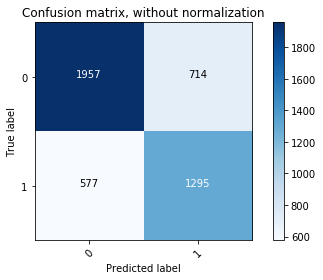

In [126]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.73268439 0.26731561]
 [0.3082265  0.6917735 ]]


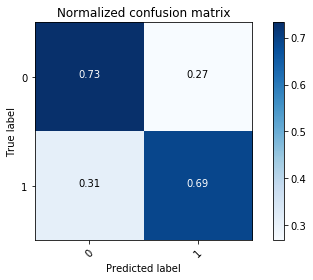

In [114]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'], normalize=True,
                      title='Normalized confusion matrix')

In [115]:
from sklearn.metrics import classification_report
print(classification_report(test[y_column], y_pred))  

             precision    recall  f1-score   support

          0       0.77      0.73      0.75      2671
          1       0.64      0.69      0.67      1872

avg / total       0.72      0.72      0.72      4543



# SVM

In [ ]:
from sklearn.svm import SVC  
svclassifier = SVC(kernel='poly')  
y_pred = svclassifier.fit(train[x_columns], train[y_column]).predict(test[x_columns])  
for i in range(0,len(y_pred)):
    y_pred[i]=math.floor(y_pred[i])

C:\Users\sara\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
cnf_matrix = confusion_matrix(test[y_column]['label'], y_pred)

Confusion matrix, without normalization
[[2638   33]
 [1687  185]]


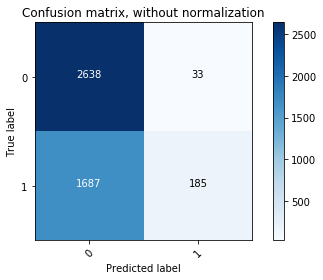

In [118]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.98764508 0.01235492]
 [0.90117521 0.09882479]]


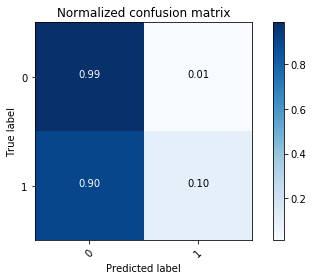

In [119]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'], normalize=True,
                      title='Normalized confusion matrix')

In [120]:
from sklearn.metrics import classification_report
print(classification_report(test[y_column], y_pred))  

             precision    recall  f1-score   support

          0       0.61      0.99      0.75      2671
          1       0.85      0.10      0.18      1872

avg / total       0.71      0.62      0.52      4543



# metodi per la classificazione automatica di apnee notturne basate su un set rdotto di sensori